# Experiment 10: Solving a Markov Decision Process (MDP)
**Student ID:** 23/CS/063 &nbsp;&nbsp; **Name:** Ankit Raj

---

## 1. Learning Objectives
- Understand MDP components (S, A, T, R, γ)
- Translate GridWorld into a formal MDP
- Implement **Value Iteration** (NumPy-only) and apply the Bellman Optimality equation
- Extract optimal policy from converged values
- Visualize and interpret value function and policy
- Analyze effects of γ and living penalty


## 2. Prerequisites
```bash
pip install numpy matplotlib
```

## 3. Task 1 — Define the GridWorld (MDP)

In [1]:
import numpy as np

ROWS, COLS = 3, 4
WALL = (1, 1)
GOAL = (0, 3)
PIT  = (1, 3)
TERMINALS = {GOAL, PIT}

ACTIONS = ['up', 'down', 'left', 'right']
ACT_TO_DELTA = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1),
}

SLIP_LEFT = {'up':'left','down':'right','left':'down','right':'up'}
SLIP_RIGHT= {'up':'right','down':'left','left':'up','right':'down'}

def in_bounds(s):
    r, c = s
    return 0 <= r < ROWS and 0 <= c < COLS

def step(s, a):
    if s in TERMINALS:
        return s
    dr, dc = ACT_TO_DELTA[a]
    ns = (s[0] + dr, s[1] + dc)
    if not in_bounds(ns) or ns == WALL:
        return s
    return ns

def get_all_states():
    return [(r,c) for r in range(ROWS) for c in range(COLS) if (r,c) != WALL]

def make_rewards(living_penalty=-0.04):
    R = {}
    for s in get_all_states():
        if s == GOAL:
            R[s] = 1.0
        elif s == PIT:
            R[s] = -1.0
        else:
            R[s] = living_penalty
    return R

def get_next_states(s, a):
    if s in TERMINALS:
        return [(1.0, s)]
    intended = step(s, a)
    left = step(s, SLIP_LEFT[a])
    right = step(s, SLIP_RIGHT[a])
    return [(0.8, intended), (0.1, left), (0.1, right)]

get_all_states()

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3)]

## 4. Task 2 — Value Iteration (NumPy-only)

In [2]:
def value_iteration(gamma=0.99, theta=1e-4, living_penalty=-0.04):
    R = make_rewards(living_penalty)
    states = get_all_states()
    V = {s: 0.0 for s in states}
    V[GOAL] = 0.0
    V[PIT]  = 0.0
    def q_value(s, a):
        return sum(p * (R[ns] + gamma * V[ns]) for p, ns in get_next_states(s, a))
    while True:
        delta = 0.0
        for s in states:
            if s in TERMINALS:
                continue
            v = V[s]
            V[s] = max(q_value(s, a) for a in ACTIONS)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V

## 5. Task 3 — Policy Extraction

In [3]:
ARROWS = {'up':'^', 'down':'v', 'left':'<', 'right':'>'}

def extract_policy(V, gamma=0.99, living_penalty=-0.04):
    R = make_rewards(living_penalty)
    policy = {}
    def q_value(s, a):
        return sum(p * (R[ns] + gamma * V[ns]) for p, ns in get_next_states(s, a))
    for s in get_all_states():
        if s in TERMINALS:
            policy[s] = None
        else:
            qs = [(a, q_value(s, a)) for a in ACTIONS]
            policy[s] = max(qs, key=lambda x: x[1])[0]
    return policy

## 6. Task 4 — Visualization & Analysis

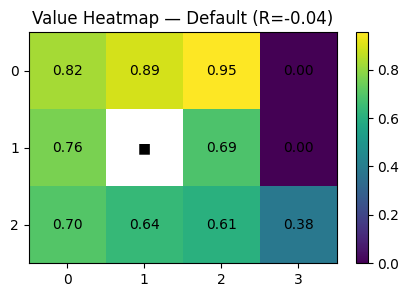

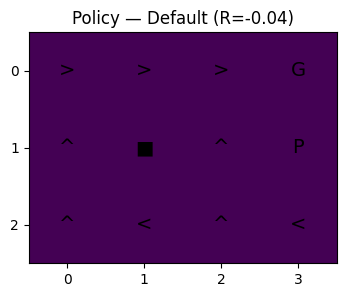

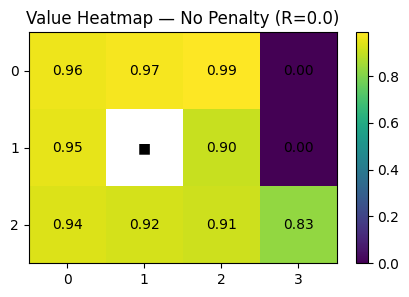

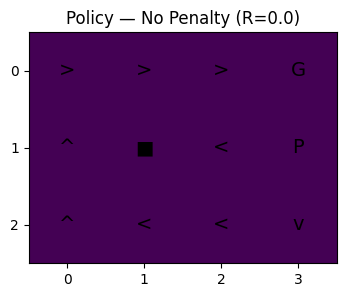

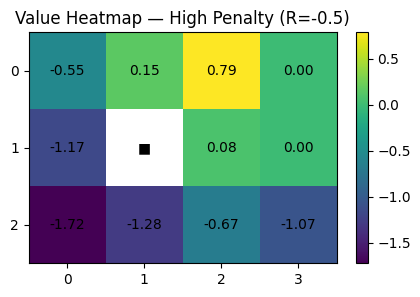

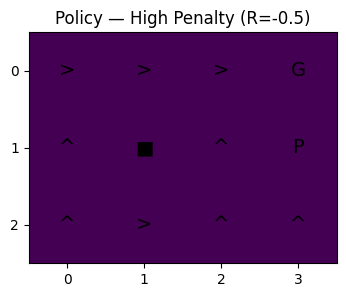

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def values_to_grid(V):
    grid = np.full((ROWS, COLS), np.nan)
    for r in range(ROWS):
        for c in range(COLS):
            if (r,c) == WALL:
                continue
            grid[r,c] = V.get((r,c), np.nan)
    return grid

def plot_value_heatmap(V, title):
    grid = values_to_grid(V)
    plt.figure(figsize=(5,3))
    plt.imshow(grid, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    for (i, j), val in np.ndenumerate(grid):
        if not np.isnan(val):
            plt.text(j, i, f"{val:.2f}", ha='center', va='center')
        else:
            plt.text(j, i, '■', ha='center', va='center')
    plt.xticks(range(COLS))
    plt.yticks(range(ROWS))
    plt.show()

def policy_to_grid(policy):
    grid = np.full((ROWS, COLS), '', dtype=object)
    for r in range(ROWS):
        for c in range(COLS):
            s = (r,c)
            if s == WALL: grid[r,c] = '■'
            elif s == GOAL: grid[r,c] = 'G'
            elif s == PIT:  grid[r,c] = 'P'
            else:
                a = policy.get(s, None)
                grid[r,c] = ARROWS[a] if a else ''
    return grid

def plot_policy_grid(policy, title):
    grid = policy_to_grid(policy)
    plt.figure(figsize=(5,3))
    plt.imshow(np.zeros((ROWS, COLS)), vmin=0, vmax=1)
    for (i, j), val in np.ndenumerate(grid):
        plt.text(j, i, val, ha='center', va='center', fontsize=14)
    plt.title(title)
    plt.xticks(range(COLS))
    plt.yticks(range(ROWS))
    plt.show()

# Default run (R=-0.04)
V_default = value_iteration(gamma=0.99, theta=1e-4, living_penalty=-0.04)
pi_default = extract_policy(V_default, gamma=0.99, living_penalty=-0.04)
plot_value_heatmap(V_default, "Value Heatmap — Default (R=-0.04)")
plot_policy_grid(pi_default, "Policy — Default (R=-0.04)")

# Q1/Q2/Q3: change penalties
V_zero = value_iteration(gamma=0.99, theta=1e-4, living_penalty=0.0)
pi_zero = extract_policy(V_zero, gamma=0.99, living_penalty=0.0)
plot_value_heatmap(V_zero, "Value Heatmap — No Penalty (R=0.0)")
plot_policy_grid(pi_zero, "Policy — No Penalty (R=0.0)")

V_high = value_iteration(gamma=0.99, theta=1e-4, living_penalty=-0.5)
pi_high = extract_policy(V_high, gamma=0.99, living_penalty=-0.5)
plot_value_heatmap(V_high, "Value Heatmap — High Penalty (R=-0.5)")
plot_policy_grid(pi_high, "Policy — High Penalty (R=-0.5)")